<a href="https://colab.research.google.com/github/zeeshanahmad54/Restaurant_Menu_Clustering/blob/main/Zeeshan_USC_GRA_Language_Modeling_for_Nutrition_SBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# To wrap output text:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Install dependencies

In [3]:
!pip install sentence_transformers
!pip install pyyaml==5.4.1
!pip install umap-learn hdbscan
!pip install kaleido==0.1.0

## Import packages

In [4]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import heapq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from __future__ import print_function
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import umap   
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer


# Converting all menu to singular form may help but will interfere with food like 'fries' and 'stir fry'
# import nltk
# nltk.download('omw-1.4')
# from pattern.text.en import singularize

## 1. Download the MenuItem dataset

In [5]:
!gdown 1vvv90qSnYqnXJ78kabs_nKvVpwRc8Dip

Downloading...
From: https://drive.google.com/uc?id=1vvv90qSnYqnXJ78kabs_nKvVpwRc8Dip
To: /content/MenuItem.csv
100% 200k/200k [00:00<00:00, 85.0MB/s]


## 2. Data Loading and Preprocessing

In [6]:
menu_df = pd.read_csv('/content/MenuItem.csv', index_col=None, header=0)

Preprocess the restaurant menu data

In [7]:
def preprocess_menu_df(menu):
  # Convert data to lower case, remove non alpha chars, and remove several unit of measurements 
  # (Units of measurements to be preserved if similarity among restaurants requires matching quantities of food)

  menu['Original food Item'] = menu['Original food Item'].str.lower()
  menu['Original food Item'] = menu['Original food Item'].str.replace('[^a-zA-Z ]+', '', regex=True)

  # its good to keep words like slice as some pizza restaurants refer to pizza as slices
  stopwords = ['oz', 'oz.', 'fl', 'fl.', 'in.', 'inch', 'lb', 'lb.', 'piece', 'serving', 'servings', 'small', 'medium', 'large']
  menu['Original food Item'] = menu['Original food Item'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
  
  return menu

menu_df = preprocess_menu_df(menu_df)

Aggregate all menu items of a single restaurant into a single row

In [8]:
concat_menu_df = menu_df.groupby(['Restaurant Name'])['Original food Item'].apply(' '.join).reset_index()

## 3. Restaurant Menu Embeddings (vectors) Exploration

Load the all-mpnet-base-v2 model available at https://huggingface.co/sentence-transformers/all-mpnet-base-v2 [1]

In [9]:
if torch.cuda.is_available():
    model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
else:
    model = SentenceTransformer('all-mpnet-base-v2', device='cpu')
# model = SentenceTransformer('stsb-roberta-large', device='cuda') #low quality embeddings according to sbert website

Obtain embeddings for each restaurant menu and compute a similarity matrix among all restaurants (341 x 341 matrix)

In [ ]:
menu_items = list(concat_menu_df['Original food Item'])
SBERT_menu_items_embeddings = model.encode(menu_items)

menu_items_cos_sim_sbert = util.cos_sim(SBERT_menu_items_embeddings, SBERT_menu_items_embeddings)
print("Cosine-Similarity:", menu_items_cos_sim_sbert)

In [11]:
# from simcse import SimCSE

# SimCSE_model = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased")
# cos_sim_menu_items = SimCSE_model.similarity(menu_items, menu_items)
# SimCSE_menu_items_embeddings = SimCSE_model.encode(menu_items)

Visualize the similarity matrix obtained

341


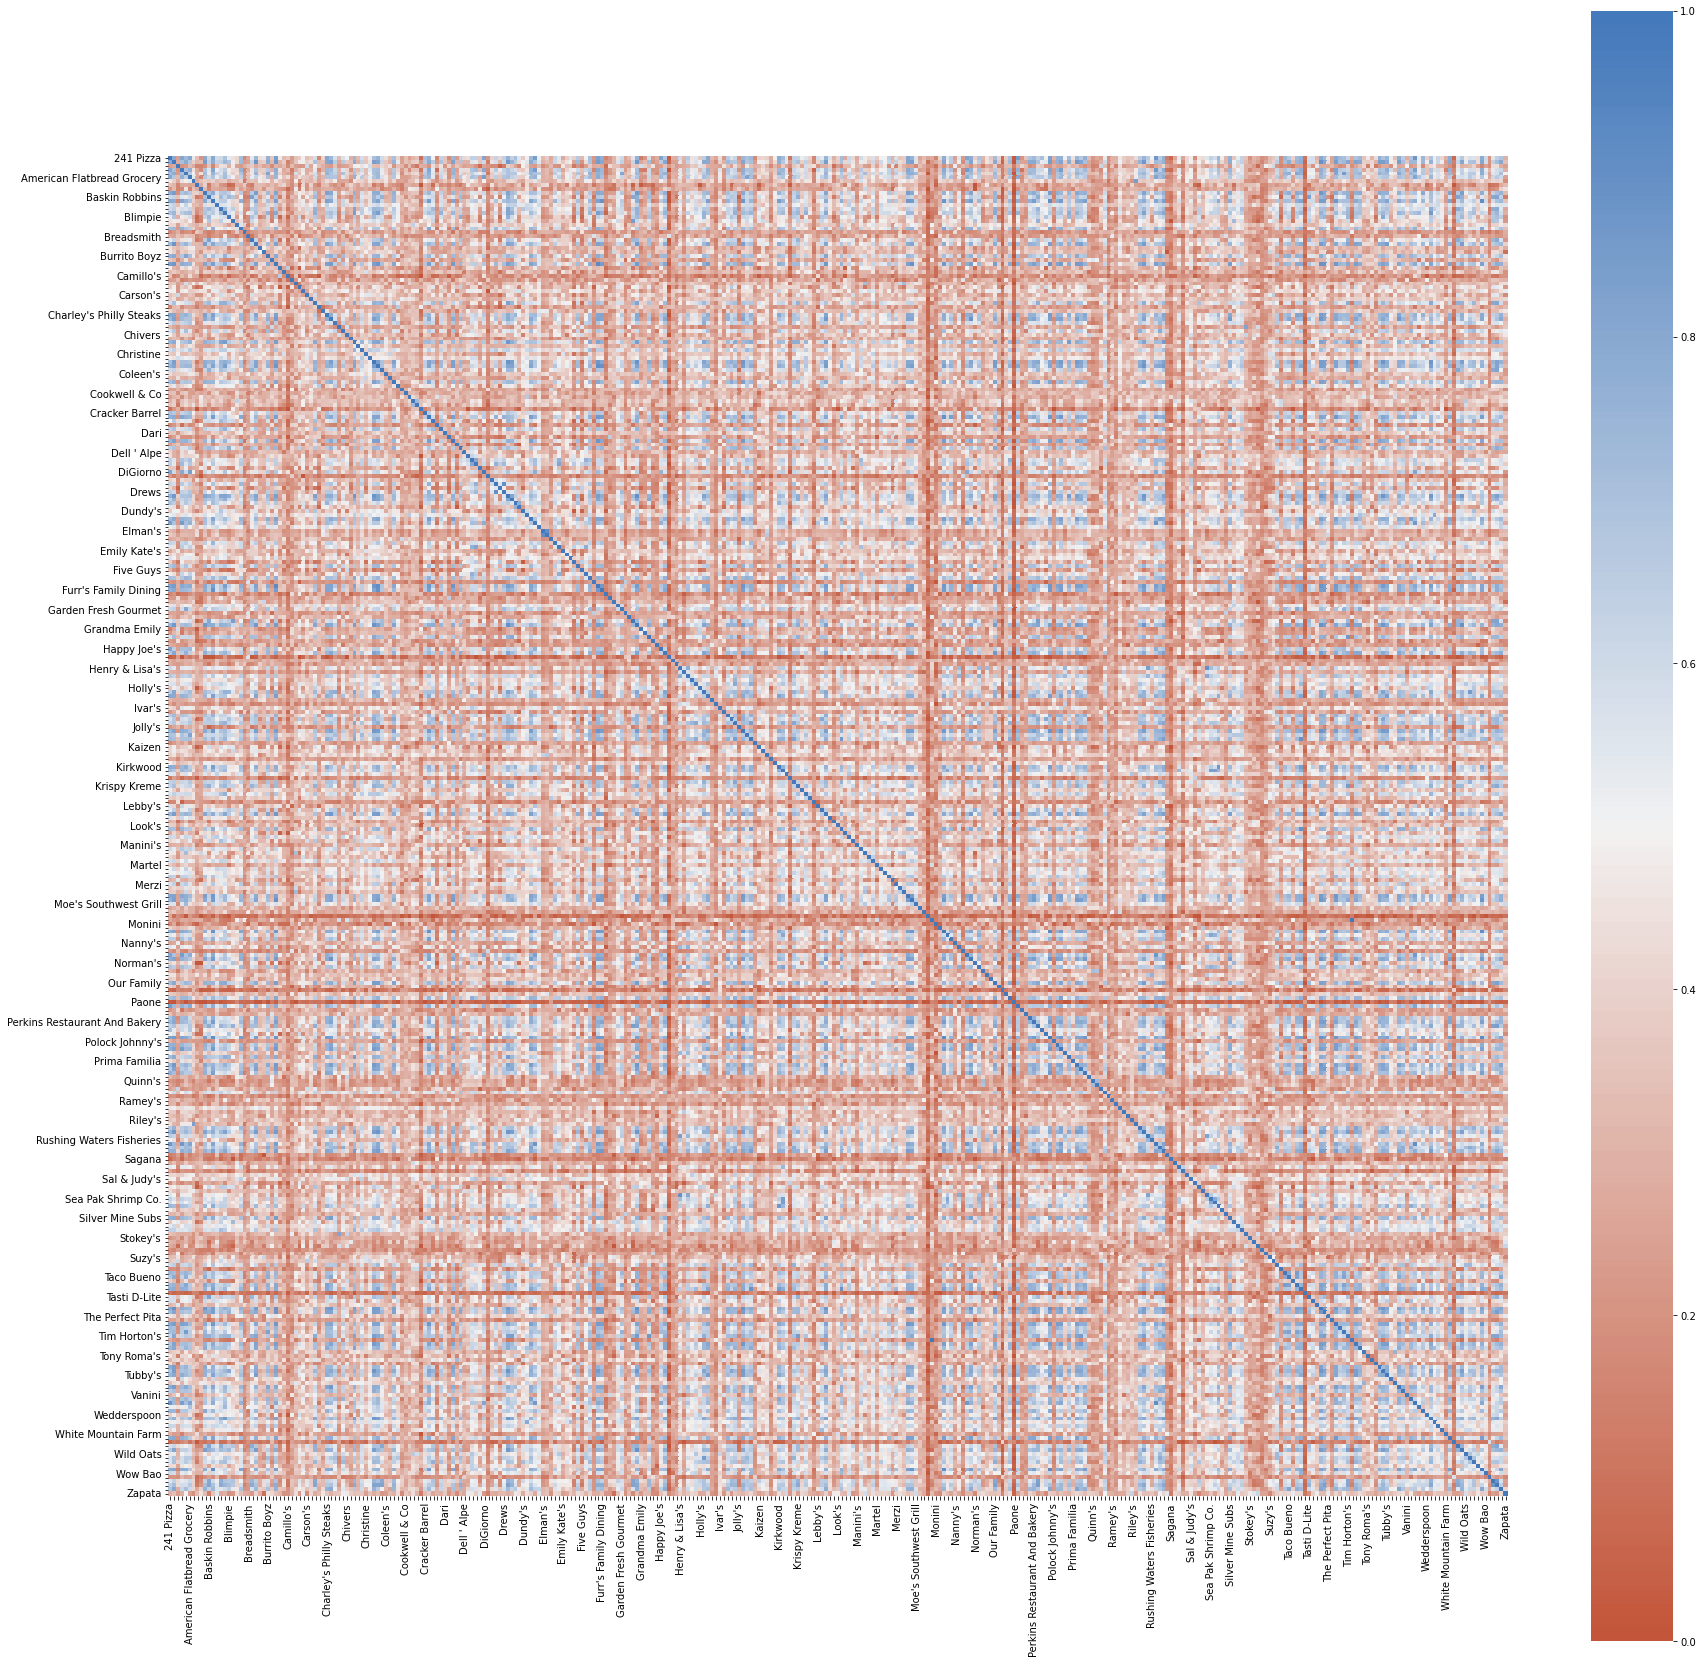

In [ ]:
# Plot a 2D similarity matrix (341x341 Mat) for all restaurants

labels = concat_menu_df['Restaurant Name']
print(len(labels))
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(
    menu_items_cos_sim_sbert, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 250, n=200),
    square=True,
    xticklabels=labels,
    yticklabels=labels,
)

# To hide every 5th Label
# for label in ax.xaxis.get_ticklabels()[::5]:
#     label.set_visible(False)
# for label in ax.yaxis.get_ticklabels()[::5]:
#     label.set_visible(False)

# To display every 5th Label
for (i,l) in enumerate(ax.yaxis.get_ticklabels()):
  if i % 5 != 0:
    l.set_visible(False)
for (i,l) in enumerate(ax.xaxis.get_ticklabels()):
  if i % 5 != 0:
    l.set_visible(False)

Obtain the top 3 similar restaurants per restaurant based on the cosine similarity metric

In [ ]:
num = 4 # n = 4 because the restaurant itself will be included in the initial list

for idx, row in enumerate(menu_items_cos_sim_sbert):
  top4_sim_restaurants_simcse = heapq.nlargest(4, row)
  # print(idx, top4_sim_restaurants_simcse)

top4_sim_restaurants_simcse_idx = np.argpartition(menu_items_cos_sim_sbert, -num, axis=1)[:, -num:]
# print(top4_sim_restaurants_simcse_idx)

# Delete the instances of the index in sim matrix if it matches with row index
top4_sim_restaurants = [[x for x in top4_sim_restaurants_simcse_idx[row] if x != row] for row in range(len(top4_sim_restaurants_simcse_idx))]

Display top 3 similar restaurants for every restaurant.


---


For example: The restaurants most similar to **241 Pizza** based on menu are:
**Vocelli Pizza**, **Russo's New York Pizzeria**, and **Papa Murphy's**

**NOTE**: Complete similarity results printed at the end of the notebook!

In [ ]:
for idx, row in enumerate(top4_sim_restaurants):
  print(f"Restaurant {idx}: {concat_menu_df['Restaurant Name'].iloc[idx]}, Menu: {concat_menu_df['Original food Item'].iloc[idx]}")
  print("\n")
  for rest_idx, rest in enumerate(row.tolist()[::-1]):
    print(f"Sim {rest_idx}, Restaurant: {concat_menu_df['Restaurant Name'].iloc[rest]}, Menu: {concat_menu_df['Original food Item'].iloc[rest]}\n")
  print("\n")

### 2D visualization of similarity of restaurants

We plot the menu of each of the 341 restaurant in 2D space.

Since BERT vectors are 728 dimensional vectors, it is difficult to vizualize them. Thus, we reduce our embeddings to 2 dimensions using TSNE dimensional reduction technique and plot these embeddings along the X and Y axes.

From the below plot, we can already start seeing some clusters of restaurants (Pizza restaurants are clustered together towards the top right, a few taco places are clusterd on the top left, dessert shops are clustered together in the mid-left, etc.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


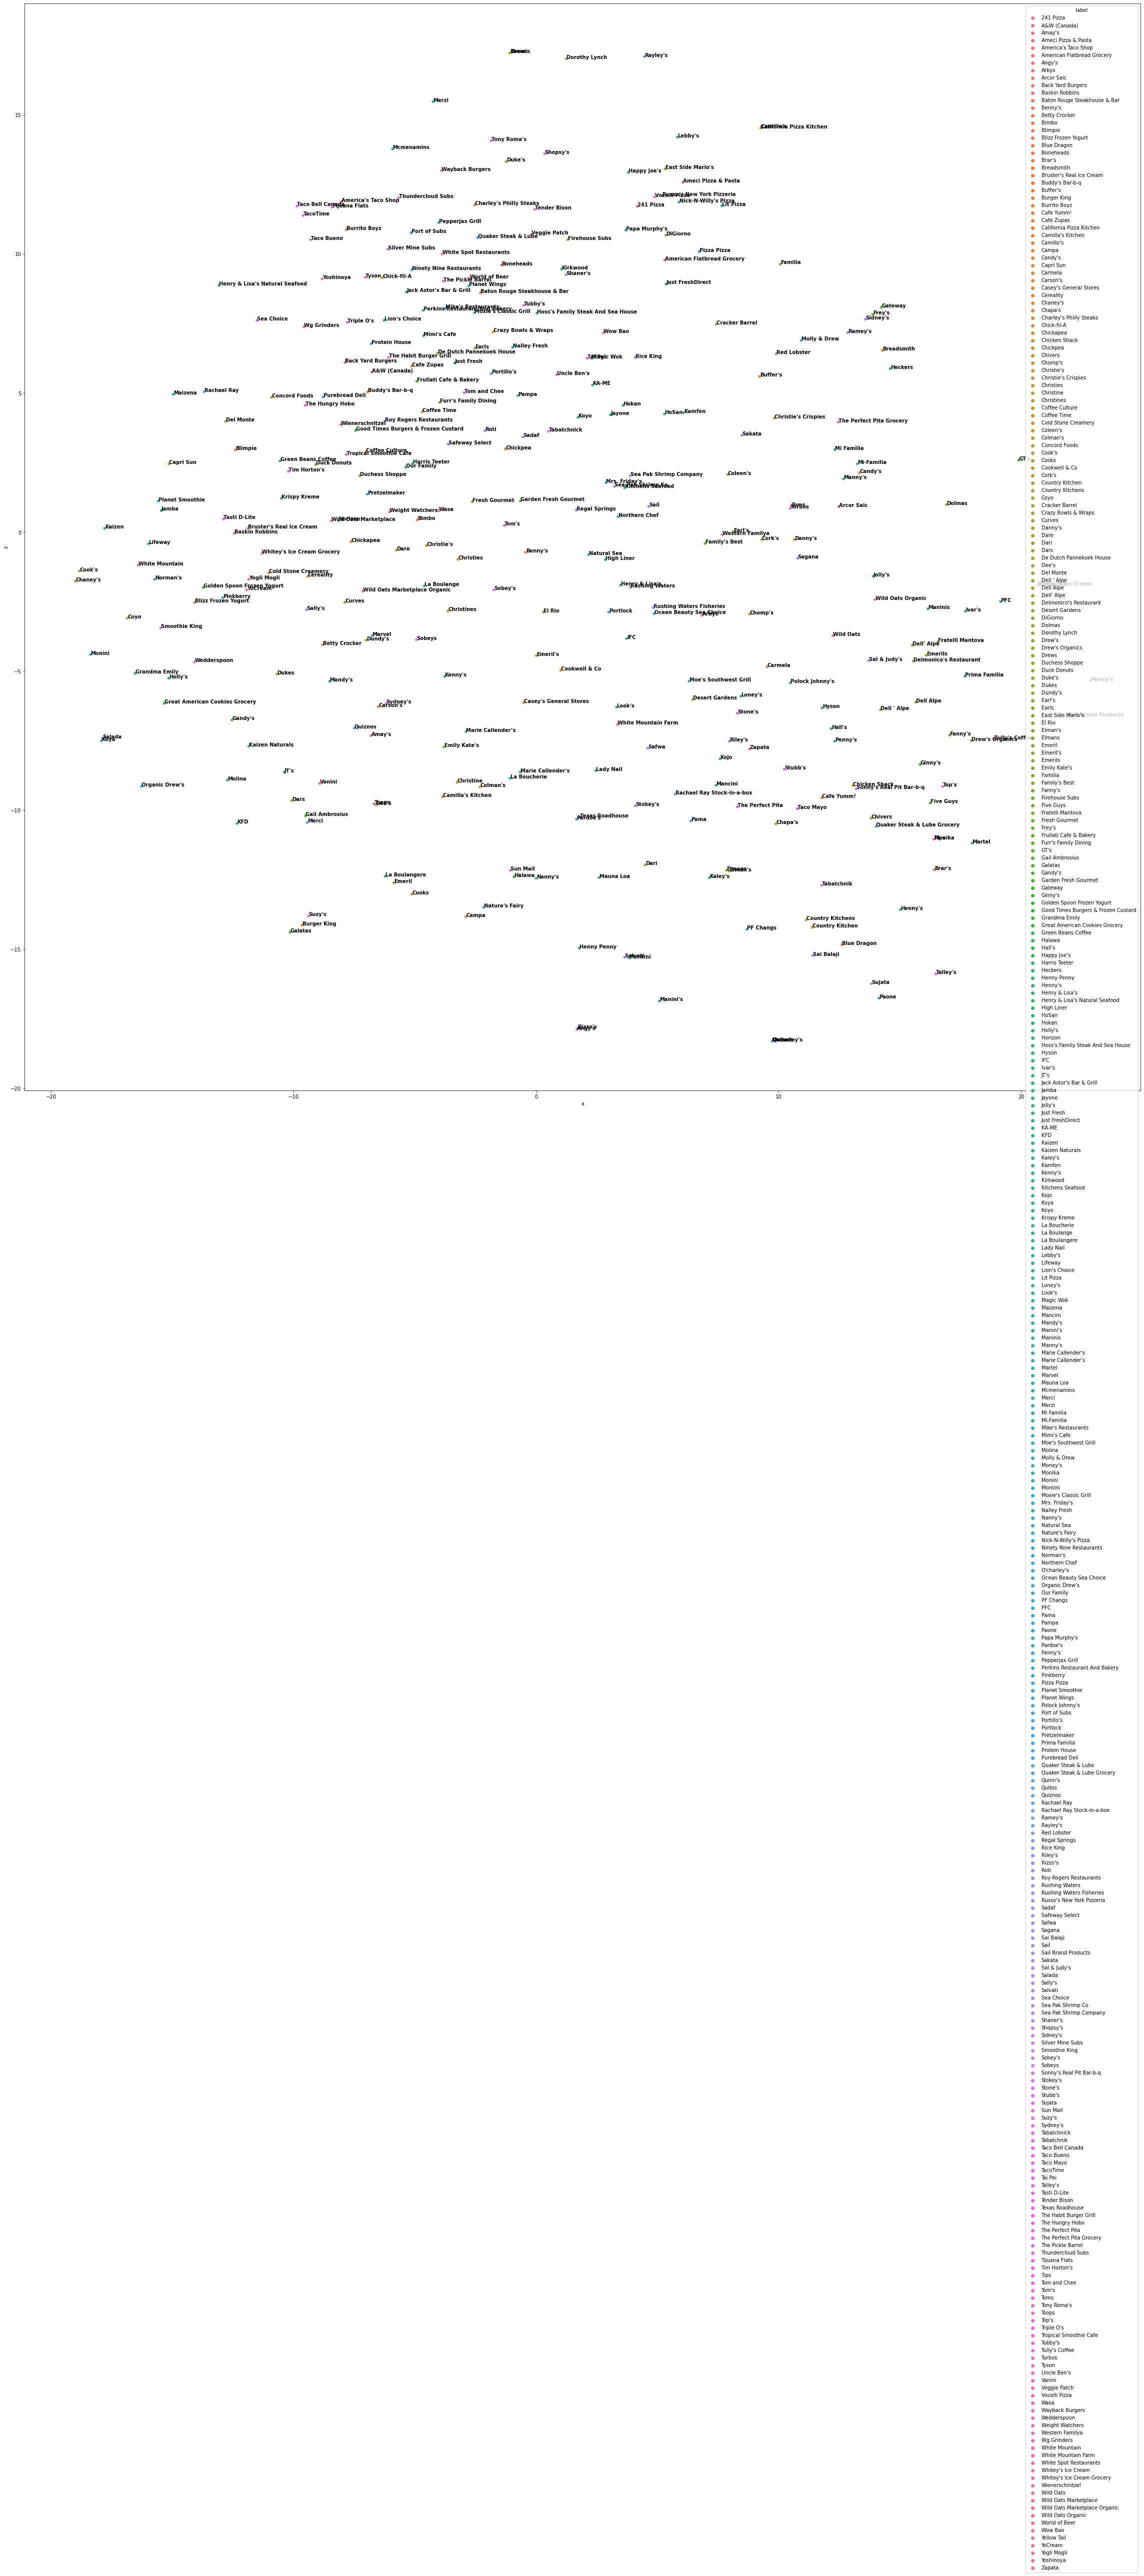

In [ ]:
dim_reducer = TSNE(n_components=2)
fig = plt.figure(figsize=(40,40))
# ax = fig.add_subplot(4,4,1)

ys = concat_menu_df['Restaurant Name'].to_numpy().reshape(-1)
dim_reduced_vectors = dim_reducer.fit_transform(SBERT_menu_items_embeddings)
df = pd.DataFrame.from_dict({'x':dim_reduced_vectors[:,0],'y':dim_reduced_vectors[:,1],'label':ys})

p1 = sns.scatterplot(data=df,x='x',y='y',hue='label', legend="full")#,ax=ax)

for line in range(0,df.shape[0]):
     p1.text(df.x[line]+0.01, df.y[line], df.label[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

### Interactive 3D visualization of similarity of restaurants

In [12]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(SBERT_menu_items_embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 341 samples in 0.001s...
[t-SNE] Computed neighbors for 341 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 341 / 341
[t-SNE] Mean sigma: 0.293688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 131.024658
[t-SNE] KL divergence after 500 iterations: 2.887557
t-SNE done! Time elapsed: 2.8567848205566406 seconds


**NOTE**: The 3D chart is only interactive in Google Colab or other notebook viewers!

341
341 341


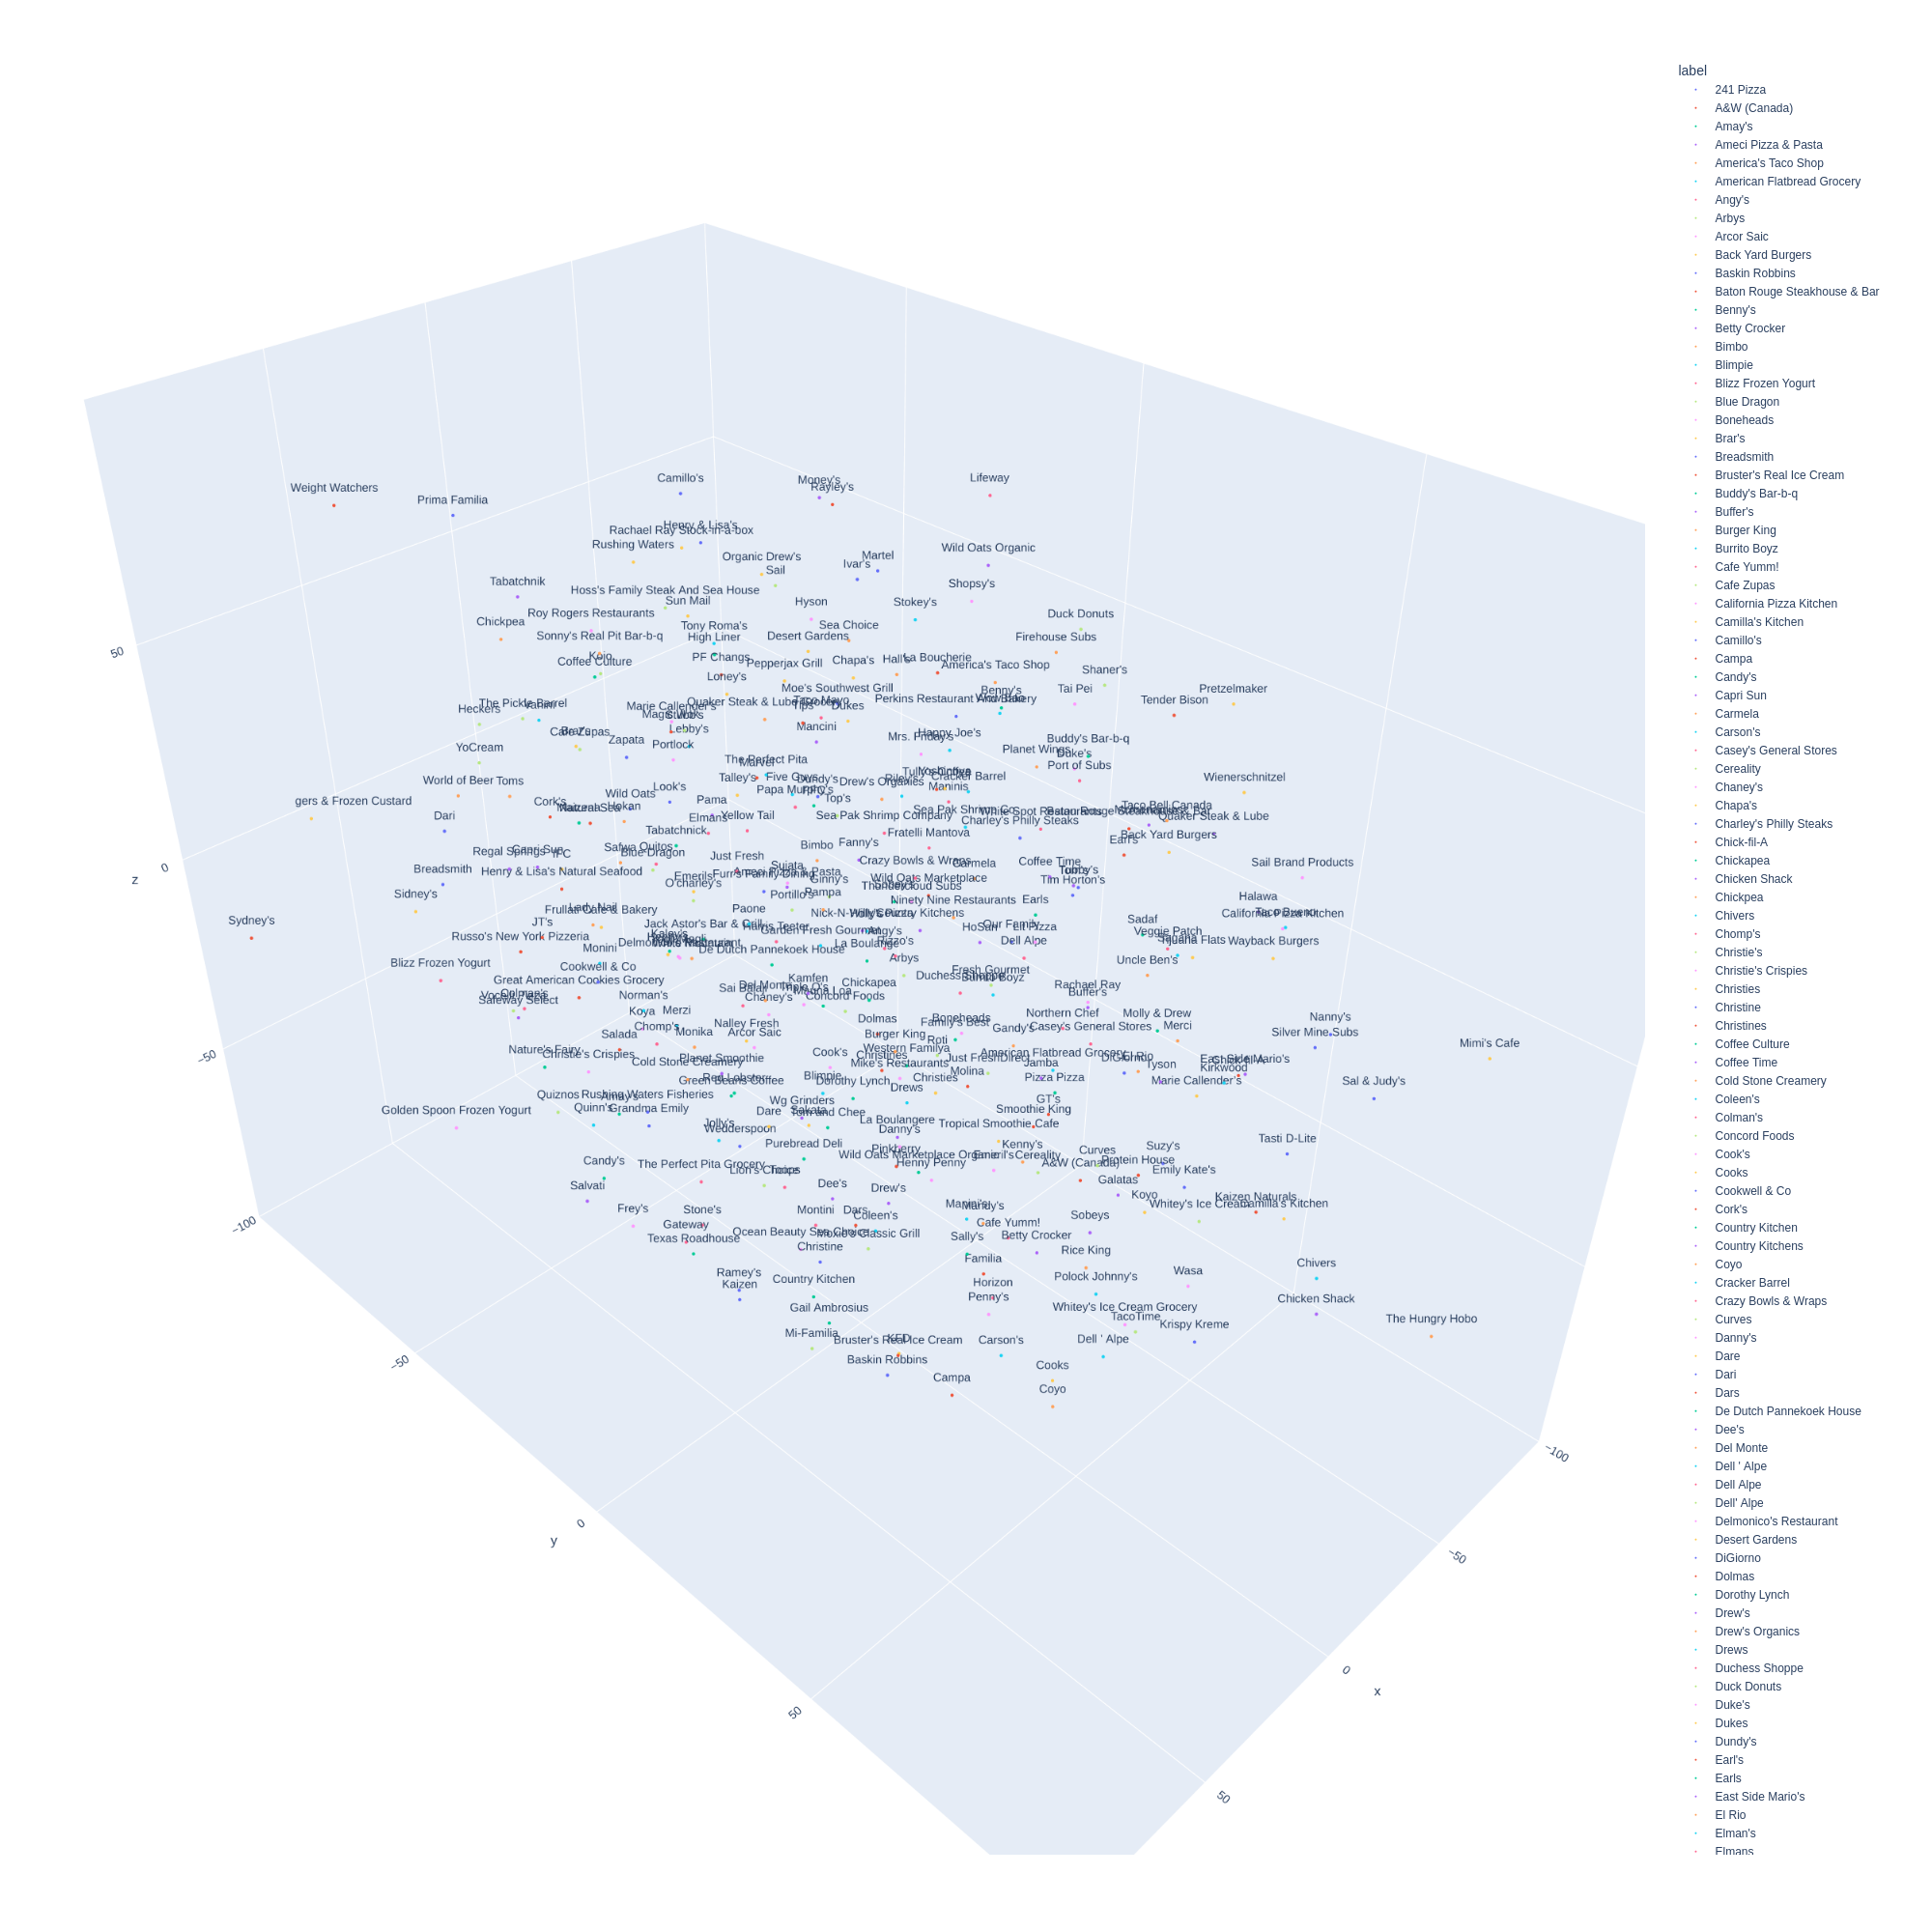

In [13]:
import plotly.express as px
import kaleido

tsne_plot_labels = concat_menu_df['Restaurant Name'].to_numpy().reshape(-1)
print(len(tsne_plot_labels))
df_tsne = pd.DataFrame.from_dict({'x':tsne_results[:,0],'y':tsne_results[:,1],'z':tsne_results[:,2], 'label':tsne_plot_labels})
print(len(tsne_results), len(df_tsne))

fig = px.scatter_3d(df_tsne, x='x', y='y', z='z',
              color='label', text='label', range_x=[-100,100], range_y=[-100,100], range_z=[-100,100], width=2000, height=2000)
fig.update_traces(marker_size = 2)

fig.show()
fig.show("png")

## 4. Clustering semantically similar restaurant brands

In order to cluster the restaurant brands, we first use UMAP for dimensionality reduction since UMAP maintains a lot of local structure even in lower-dimensional space [2]. We reduce the dimension of the embeddings to 5, and then perform an HDBSCAN on the reduced dim embeddings. We choose HDBSCAN as it is resistant to noise and does not force every point into a cluster.



In [ ]:
SBERT_menu_items_umap_embeddings = umap.UMAP(n_neighbors=5, n_components=5, metric='cosine').fit_transform(SBERT_menu_items_embeddings)

In [ ]:
SBERT_menu_items_embeddings_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          min_samples = 2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(SBERT_menu_items_umap_embeddings)

# SBERT_menu_items_embeddings_cluster.labels_

Each Restaurant Brand with its cluster label can be seen below

In [127]:
clustered_menu_df = pd.DataFrame(concat_menu_df, columns=['Restaurant Name', 'Original food Item'])
clustered_menu_df['Cluster_Category'] = SBERT_menu_items_embeddings_cluster.labels_
clustered_menu_df.sort_values('Cluster_Category')

,Restaurant Name,Original food Item,Cluster_Category
170,Look's,herring fillets jacobs cattle beans new englan...,-1
211,PF Changs,dumplings chicken and vegetable,-1
209,Organic Drew's,blueberry pomegranate with chia dressing black...,-1
55,Coleen's,cheese infused artisan breadsticks three chees...,-1
29,Camilla's Kitchen,sweet belgian waffles belgian waffles,-1
...,...,...,...
281,Sydney's,ginger snap cookie chocolate chip brownie,9
87,Duck Donuts,bagel blueberry bagel with cream cheese bagel ...,9
86,Duchess Shoppe,hersheys triple chocolate cookie cherry coca c...,9
23,Buffer's,steak mushroom cheddar flatbread melt,9


To visualize the clusters created above, we further reduce the dimension of our embeddings to 2 and plot them on a 2D plane. Outliers (points not belonging to any cluster) are colored gray in the resulting plot

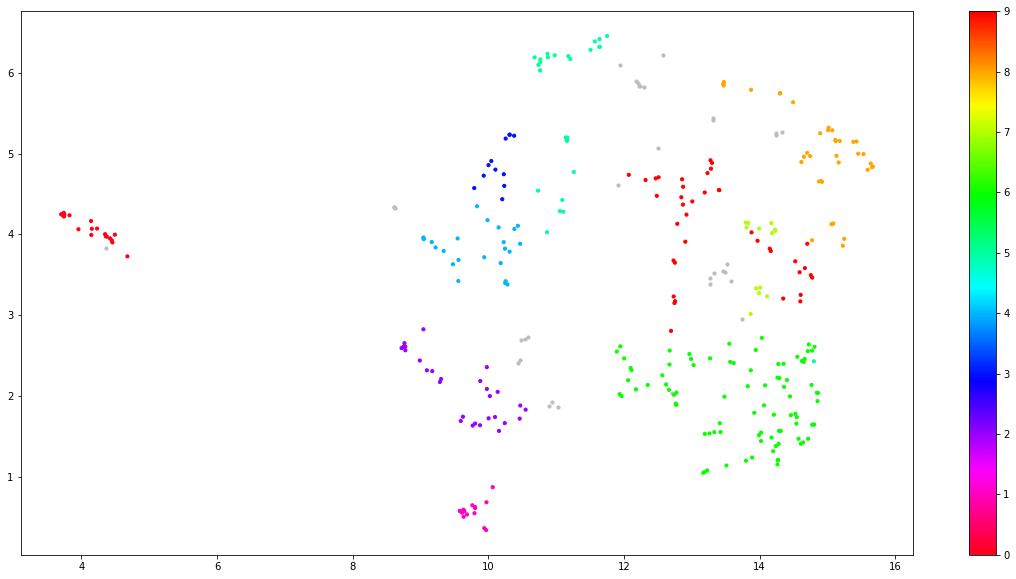

In [ ]:
# reduce embedding space to 2
umap_menu_items_embeddings = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(SBERT_menu_items_embeddings)
result = pd.DataFrame(umap_menu_items_embeddings, columns=['x', 'y'])
result['labels'] = SBERT_menu_items_embeddings_cluster.labels_

# Plot the clusters in a 2D plane
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()

## 5. Evaluating Clusters

### Topic Modeling of clusters

Finally, to evaluate clusters, we follow a **topic modeling** approach similar to Grootendorst (2022) [3] and Angelov (2020) [4] where topics are derived from clustered embeddings using a class-based variant of TF-IDF (c-TF-IDF)

We combine all the restaurant menus belonging to a given cluster into a single document and then apply TF-IDF to get the most frequent words (menu items) per cluster

In [134]:
topic_mod_menu_df = pd.DataFrame(concat_menu_df, columns=['Restaurant Name', 'Original food Item'])
topic_mod_menu_df['Category'] = SBERT_menu_items_embeddings_cluster.labels_
topic_mod_menu_df['Desc_ID'] = range(len(topic_mod_menu_df))
desc_per_topic = topic_mod_menu_df.groupby(['Category'], as_index = False).agg({'Original food Item': ' '.join})

In [ ]:
# Generates a cluster based tf_idf score

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [144]:
# Obtain the top 20 words per cluster based on the cluster based TF-IDF scores

tf_idf, count = c_tf_idf(desc_per_topic['Original food Item'].values, m=len(concat_menu_df))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Category)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Category'])
                     ['Original food Item']
                     .count()
                     .reset_index()
                     .rename({"Category": "Cluster", "Original food Item": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, desc_per_topic, n=20)
cluster_sizes = extract_topic_sizes(topic_mod_menu_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [140]:
cluster_sizes

,Cluster,Size
7,6,88
10,9,39
9,8,38
0,-1,35
3,2,28
6,5,28
5,4,24
1,0,20
2,1,16
8,7,13


From the below list of top words per cluster, we can see that we can cluster Restaurant Brands based on the type of food they serve. 

Cluster #0 - Restaurants belonging to Cluster #0 serve **fish and other sea foods**.

Cluster #1 - Restaurants belonging to Cluster #1 are **pizza places**.

Cluster #2 - Restaurants in Cluster #2 are restaurants serving **Italian** food.

Cluster #3 - Cluster #3 belongs to **Vegan restaurants**.

Cluster #4 - Cluster #4 appears to belong to **Mediterranean restaurants**.

Cluster #5 - Similarly, Cluster #5 contains restaurants serving **Mexican food**.

Cluster #6 - Restaurants belonging to Cluster #6 serve **Burgers, frieds, and sandwiches**.

Cluster #7 - Shops and Restaurants belonging to Cluster #7 seem to specialize in **breakfast items like cereals and granolas**.

Cluster #8 - Cluster #8 has restaurants serving desserts such as **ice creams and yogurts**.

Cluster #9 - Finally, Restaurants in Cluster #9 appear to be **Cafes**.

In [145]:
top_n_words

{-1: ['bread',
  'rye',
  'pie',
  'style',
  'home',
  'chia',
  'belgian',
  'artisan',
  'pot',
  'grated',
  'free',
  'salsa',
  'waffles',
  'olive',
  'flour',
  'cheesecake',
  'oil',
  'new',
  'pomegranate',
  'cattle'],
 0: ['shrimp',
  'salmon',
  'cod',
  'wild',
  'fillets',
  'tilapia',
  'breaded',
  'butterfly',
  'pacific',
  'cooked',
  'alaska',
  'tuna',
  'alaskan',
  'fillet',
  'albacore',
  'caught',
  'premium',
  'burgers',
  'crab',
  'fish'],
 1: ['slice',
  'crust',
  'pizza',
  'pan',
  'topping',
  'pepperoni',
  'family',
  'original',
  'pesto',
  'party',
  'meat',
  'supreme',
  'hawaiian',
  'personal',
  'rising',
  'plant',
  'based',
  'pasta',
  'lunch',
  'calzone'],
 2: ['italian',
  'tortellini',
  'pasta',
  'organic',
  'pesto',
  'sauce',
  'zuppa',
  'genovese',
  'toscana',
  'ricotta',
  'quartered',
  'hearts',
  'tomatoes',
  'tomato',
  'marinara',
  'linguine',
  'basil',
  'grated',
  'romano',
  'marinated'],
 3: ['peanuts',
  'gr

2D and interactive 3D visualizations of all the restaurant brands has been shown in detail in section 3. 

## References

1. Pretrained BERT model -  https://huggingface.co/sentence-transformers/all-mpnet-base-v2
2. UMAP - https://github.com/lmcinnes/umap
3. Topic modeling - https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
4. Top2Vec - https://arxiv.org/abs/2008.09470


## Top 3 restaurant brands for each restaurant brand

Display top 3 similar restaurants for every restaurant.


---


For example: The restaurants most similar to **241 Pizza** based on menu are:
**Vocelli Pizza**, **Russo's New York Pizzeria**, and **Papa Murphy's**

In [ ]:
for idx, row in enumerate(top4_sim_restaurants):
  print(f"Restaurant {idx}: {concat_menu_df['Restaurant Name'].iloc[idx]}, Menu: {concat_menu_df['Original food Item'].iloc[idx]}")
  print("\n")
  for rest_idx, rest in enumerate(row.tolist()[::-1]):
    print(f"Sim {rest_idx}, Restaurant: {concat_menu_df['Restaurant Name'].iloc[rest]}, Menu: {concat_menu_df['Original food Item'].iloc[rest]}\n")
  print("\n")

Restaurant 0: 241 Pizza, Menu: bacon cheeseburger pizza slice meat lovers pizza slice bbq chicken pizza slice meat lovers pizza slice garlic bread with cheese ranch dipping sauce cauliflower pizza crust meat lovers pizza slice potato wedges pepperoni plant based pizza slice chicken club pizza slice chorizo supreme pizza slice chorizo supreme pizza slice pepperoni pizza slice pepperoni pizza slice jalapeno hawaiian pizza slice pepperoni plant based pizza slice bbq wings hawaiian pizza slice basil pesto pizza slice canadian pizza slice canadian supreme plant based pizza slice hawaiian pizza slice canadian supreme plant based pizza slice bacon cheeseburger pizza slice veggie sensation pizza slice spicy buffalo dipping sauce jalapeno hawaiian pizza slice veggie sensation pizza slice pepperoni pizza slice basil pesto pizza slice hot wings chicken club pizza slice gravy deluxe pizza slice bbq dipping sauce poutine cheese pizza slice canadian supreme plant based pizza slice garden salad hawai